# Messy Notebook where I try to analyze data from Zotero


## Imports, global variables and Zotero session


In [14]:
# --- Import ---
# Core
from pyzotero import zotero
from pathlib import Path
import numpy as np
import pandas as pd
import pandas


from pandas.core.series import Series

# Additional
import matplotlib.pyplot as plt
import squarify


import re
import tabulate
from pprint import pprint
from tqdm import tqdm
import datetime

# --- Settings ---
group_library_id = "5602981"
user_library_id = "8968938"  # From: https://www.zotero.org/settings/keys
library_type = "group"  # To access the shared library, otherwise for private "user"
api_key = "jTbkXBSx7Yv0GyOQU3its5Gb"

# Quick ANSI color code shortcuts
r = "\033[31m"


y = "\033[33m"
g = "\033[32m"
b = "\033[34m"
e = "\033[0m"

# Paths to save tmp Dataframes
path_to_dataframes = Path("..") / "data" / "Review_ML-RS-FPGA" / "Dataframes"
all_articles_df_pkl = (
    path_to_dataframes
    / f"all_articles_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
)
models_df_pkl = (
    path_to_dataframes
    / f"all_datapoints_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
)


# --- Zotero API initialization ---
zot = zotero.Zotero(group_library_id, library_type, api_key)
print(zot)

### Methods


In [15]:
# --- Quick lambda functions ---
from typing import Literal
from pandas.core.frame import DataFrame

get_total_in_dict_of_lists = lambda d: sum([len(d[tag]) for tag in d])
get_total_in_dict = lambda d: sum([d[tag] for tag in d])


def parse_string_to_dict(inputString):
    """_summary_
    Transforms a string in a Python dictionnary

    Args:
        inputString (_type_): a "dictionnary" in a string format (with several lines with "<key>: <value>")

    Returns:
        dict[Any, Any]: the dictionnary equivalent to the input string
    """
    resultDict = {}
    lines = inputString.split("\n")

    for line in lines:
        if ": " in line:
            key, value = line.split(": ", 1)
            resultDict[key.strip()] = value.strip()

    return resultDict

def extract_year(dateSTR) -> int:
    """_summary_
    Extract year from a string date. In Zotero the date can be imported in many differnt formats.
    For example: "2021-06", "2021", "2024 OCT 15", "2021 JUL", "2022/08/01", etc.
    This function identifies the year as a 4-digit number in the string.

    Args:
        dateSTR (_type_): The date in string format

    Raises:
        ValueError: If no year is found in the string

    Returns:
        int: The year.
    """
    match = re.search(r'(\d{4})', dateSTR)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f'No year found in "{dateSTR}"')

def fetch_articles_data(zoteroAPI: zotero.Zotero, keys: list[str]) -> DataFrame:
    """_summary_
    Get the title, DOI, URL, abstract, date, item type and citation key, as well the list of authors and tags of each article which key is in the provided list.

    Args:
        zoteroAPI (zotero.Zotero): The Zotero API where to get the articles
        keys (list[str]): List of keys of the articles to fetch

    Returns:
        Dataframe: A DataFrame containing the data of the articles
    """
    articlesData = []
    print(f"{y}Fetching data for {len(keys)} articles...{e}")

    for key in tqdm(keys):
        data = zoteroAPI.item(key)["data"]

        title = data.get("title", "")
        doi = data.get("DOI", "")
        url = data.get("url", "")
        abstractNote = data.get("abstractNote", "")
        date = data.get("date", "")
        itemType = data.get("itemType", "")
        extra = parse_string_to_dict(data.get("extra", ""))
        # print(f" - {g}{title}{e}...")

        authorsList = [
            f"{author['firstName']} {author['lastName']}"
            for author in data.get("creators", [])
            if author["creatorType"] == "author"
        ]

        tags = [tag["tag"] for tag in data.get("tags", [])]

        articlesData.append(
            {
                "BBT Citation Key": extra["Citation Key"],
                "Title": title,
                "List": authorsList,
                "DOI": doi,
                "URL": url,
                "Tags": tags,
                "Abstract Note": abstractNote,
                "Date": date,
                "Item Type": itemType,
                "Zotero Key": key,
            }
        )

    df = pd.DataFrame(articlesData)
    df.set_index("BBT Citation Key", inplace=True)

    return df


def get_article_main_info_from_tags(tagsList):
    """_summary_
    From the list of tags of an item, return 4 lists for each "Dataset", "Model", "Board" and "Task"
    I use it to detect if an item compares several models, possibly on several board/dataset/or even task

    Args:
        tagsList (List[str]): The list of tags (as strings) of an article

    Returns:
        dict[str, list[str]]: Dictionnary with 6 keys: "Board", "Implementation", "Modality", "Models", "Datasets" and "Tasks" and the corresponding list of tags
    """
    parsedData = {
        "Board": [],
        "Implementation": [],
        "Modality": [],
        "Models": [],
        "Datasets": [],
        "Tasks": [],
    }

    for tag in tagsList:
        if tag.startswith("Dataset:"):
            parsedData["Datasets"].append(tag.split("Dataset: ")[1].strip())
        elif tag.startswith("Model:") and tag != "Model: N/A":
            parsedData["Models"].append(tag.split("Model: ")[1].strip())
        elif tag.startswith("Board:"):
            parsedData["Board"].append(tag.split("Board: ")[1].strip())
        elif tag.startswith("Task:"):
            parsedData["Tasks"].append(tag.split("Task: ")[1].strip())
        elif tag.startswith("Implementation:"):
            parsedData["Implementation"].append(
                tag.split("Implementation: ")[1].strip()
            )
        elif tag.startswith("Modality:"):
            parsedData["Modality"].append(tag.split("Modality: ")[1].strip())

    if len(parsedData["Implementation"]) > 1:
        print(
            f"    {r}Warning{e}: Multiple Implementations detected for {b}{tagsList}{e}"
        )
    if len(parsedData["Board"]) > 1:
        print(f"    {r}Warning{e}: Multiple Boards detected for {b}{tagsList}{e}")
    if len(parsedData["Modality"]) > 1:
        print(f"    {r}Warning{e}: Multiple Modalities detected for {b}{tagsList}{e}")
    return parsedData


def find_parentheses_and_braces(fullTagModelName: str) -> tuple[int, int, int, int]:
    """Find the positions of parentheses and braces in the model name string.

    Args:
        fullTagModelName (str): The full model name string.

    Returns:
        tuple[int, int, int, int]: The start and end positions of parentheses and braces.
    """
    parenthesisStart: int = fullTagModelName.find("(")
    parenthesisEnd: int = fullTagModelName.find(")")
    braceStart: int = fullTagModelName.find("{")
    braceEnd: int = fullTagModelName.find("}")

    if (parenthesisStart == -1 and parenthesisEnd != -1) or (
        parenthesisStart != -1 and parenthesisEnd == -1
    ):
        raise ValueError(f"Parentheses are missing in {b}{fullTagModelName}{e}.")
    if (braceStart == -1 and braceEnd != -1) or (braceStart != -1 and braceEnd == -1):
        raise ValueError(f"Braces are missing in {b}{fullTagModelName}{e}.")

    return parenthesisStart, parenthesisEnd, braceStart, braceEnd


def parse_model_names_from_original_name_tag(
    fullTagModelName: str,
) -> tuple[str, str, str]:
    """_summary_
    Parse the model different names: the name used in the article, the corresponding model and the backbone from the original tag.
    The model name should be in the format "<name used in the article> (<corresponding model>) {<backbone>}".
    Example: "Improved YOLOv4-tiny 3L (YOLOv4-tiny) {Darknet53-tiny}"

    Raises:
        ValueError: if Parentheses or Braces are missing in the fullTagModelName

    Returns:
        tuple[str, str, str]: Tuple with the 3 components of the model name: nameUsedInArticle, nameCorrespondingModel, backbone
    """
    nameUsedInArticle = None
    nameCorrespondingModel = ""
    backbone = ""

    # Will throw an error if Parentheses or Braces are missing
    parenthesisStart, parenthesisEnd, braceStart, braceEnd = (
        find_parentheses_and_braces(fullTagModelName)
    )

    nameUsedInArticle: str = fullTagModelName[:parenthesisStart].strip()
    nameCorrespondingModel: str = fullTagModelName[
        parenthesisStart + 1 : parenthesisEnd
    ].strip()
    if nameCorrespondingModel == "":
        nameCorrespondingModel = nameUsedInArticle
    backbone: str = fullTagModelName[braceStart + 1 : braceEnd].strip()

    return nameUsedInArticle, nameCorrespondingModel, backbone


def extract_metrics_from_df_row(
    article, reportsSeveralModels=False, fullTagModelName=""
):
    """_summary_
    Extract all the systematically reported performance metric (latency, task score (aka, performance),
    model size, throughput and power consumption) from a DataFrame's row (a single article).
    If a metric is missing, it gets printed.
    The 'N/A' value (when an article did not report a metric) is set to a blank space ' ' (for clarity when printing).

    Args:
        article (pd.Series): a DataFrame's row (a single article), containing all the data of a model reported in an article.
        reportsSeveralModels (bool, optional): whether the article reports several models or not. Defaults to False.
        fullTagModelName (str, optional): the name of the model with all its info, it is ONLY used when reportsSeveralModels is True.
                                          In which case the tags with the metrics of interest start with "(<backbone>)" or "(<modelName>)". Defaults to "".

    Returns:
        dict[str, str]: Dictionary with 5 keys: "Model latency", "Model performance", "Model size", "Model throughput" and "Power consumption".
    """
    if reportsSeveralModels:
        if fullTagModelName == "":
            raise ValueError(
                f"fullTagModelName should be given when an article reports several model, see {article['BBT Citation Key']}"
            )
        else:
            modelName, _, backbone = parse_model_names_from_original_name_tag(
                fullTagModelName
            )

    metricKeys = [
        "Model latency: ",  # in ms or FPS
        "Model performance: ",  # in % OA, % F1, % mIoU, etc.
        "Model size: ",  # in MB
        "Model throughput: ",  # in GOP/s
        "Power consumption: ",  # in W
    ]

    metricsFoundDict = {}
    missingMetricsList = []

    for key in metricKeys:
        found = False
        for tag in article["Tags"]:
            if tag.startswith(key):
                # Check for the parenthesis syntax (Case 2, 5 or 6)
                if reportsSeveralModels:
                    modelNameUsedInTag = tag[len(key) :].split(")")[0][1:].strip()
                    if (
                        modelNameUsedInTag == modelName
                        or modelNameUsedInTag == backbone
                    ):
                        metricValue = tag.split(")")[1].strip()
                        metricsFoundDict[key[:-2]] = metricValue
                        found = True
                        break
                # Check for the no-parenthesis syntax (Case 1, 3 or 4)
                else:
                    metricValue = tag.split(key)[1].strip()
                    metricValue = "" if metricValue.startswith("N/A") else metricValue
                    metricsFoundDict[key[:-2]] = metricValue
                    found = True
                    break

        if found and key == "Model performance: ":
            if "Acc" in metricsFoundDict[key[:-2]]:
                print(
                    f"    {r}Acc metric warning{e} Model performance was reported as Acc in {b}{article['Title']}{e}: {g}{metricsFoundDict[key[:-2]]}{e}, replacing it by OA"
                )
                metricsFoundDict[key[:-2]] = metricsFoundDict[key[:-2]].replace(
                    "Acc", "OA"
                )

        if not found:
            metricsFoundDict[key[:-2]] = ""
            missingMetricsList.append(key[:-2])

    if missingMetricsList:
        print(
            f"    {r}Missing metric warning{e}: {b}{article['Title']}{e} misses: {r}{', '.join(missingMetricsList)}{e} metrics for {b}{modelName if reportsSeveralModels else 'its unique model'}{e}"
        )

    return metricsFoundDict

## Bonus: Playing with the API


#### Print all collections


In [16]:
# collections = zot.all_collections()
# print(len(collections), "collections in your library")
# pprint(collections)

#### Get every possible item


In [17]:
# # Zotero.everything() leverages the 100 items per request limit
# all_items = zot.everything(zot.top())
# # I have ~310 items and it takes 20s to fetch them all
# print(len(all_items), "items in your library")

#### See which possible `itemTypes` are available


In [18]:
# pprint(len(zot.item_types()))

## Access to the review collection

Key for my private user library, the `"PhD - DLR"`/`"On-board AI"`/`"Review ML / FPGA / RS"`/`"Merge with already read"` library:

- `"LWR4HAWY"`

Key for the shared library, `"included in review"`:

- `"PEWYQYGG"`


In [19]:
# Add search paprameters to select only conference papers and journal articles
# /!\ Ideally i just want to NOT select notes and attachments, but I did not find the API syntax to do so
zot.add_parameters(itemType="conferencePaper || journalArticle")
# Fetch all the items in the library (Without the limitation of 100 items per request)
# Key of the group "included in review" collection: PEWYQYGG, and key of my private user collection: LWR4HAWY
review_items = zot.everything(zot.collection_items("PEWYQYGG"))
print(len(review_items), " items in the review collection")

44  items in the review collection


### Sort articles if selected or not

All articles in the sub-collection should include the tag "ML-FPGA Review" and not have the "Outside the scope of the review" or any "Excluded: " tag.
Nevertheless, double checking doesn't hurt. 🙃


In [20]:
excluded = {}
articles_selected_for_review = []
# --- For all item ---
for item in tqdm(review_items):
    # Print the item's title and type
    # print(f"{r}{item['data']['itemType']}{e}")
    # print(f" - {b}{item['data']['title']}{e}")

    # print(f'Item Type: {item["data"]["itemType"]} | Key: {item["data"]["key"]}')
    # Get the item's tags as a list
    tags = item["data"].get("tags", [])
    is_excluded = False
    for tag in tags:
        # Weird but each tag is a dictionary with a "tag" key
        tag = tag["tag"]
        # If the tag starts with "excluded: "
        if tag.startswith("Excluded: "):
            # If the tag is not yet in the excluded dictionary
            if tag not in excluded:
                # Add the tag as a key and an empty list as the value
                excluded[tag] = []

            # Add the item's key to the list of keys for the tag
            excluded[tag].append(item["data"]["key"])
            is_excluded = True
            break
    # If the item is not excluded, add its key to the list of keys for the tag "Selected for review"
    if not is_excluded:
        articles_selected_for_review.append(item["data"]["key"])

# Verify that the total of excluded items sum up to the total number of items in the review collection
total_excluded = 0
for key in excluded:
    total_excluded += len(excluded[key])

print(
    f"{r}{total_excluded}{e} excluded items + {g}{len(articles_selected_for_review)}{e} selected for review = {b}{len(review_items)}{e} total items in the review collection"
)
assert total_excluded + len(articles_selected_for_review) == len(review_items)


# Print the excluded dictionary
print(f"Total number of items excluded: {r}{total_excluded}{e}.")
for tag, keys in excluded.items():
    print(f'{r}{len(keys):>3}{e} items excluded for: {b}"{tag[10:]}"{e}')

100%|██████████| 44/44 [00:00<00:00, 43659.66it/s]

0 excluded items + 44 selected for review = 44 total items in the review collection
Total number of items excluded: 0.


### Transform the data in a pandas `Dataframe`

After verifying that all the articles will be included in the review. Get the actual data of each item, and store it in a Dataframe.

Also, save the dataframe, if needed offline


In [21]:
# Fetch the data and create a DataFrame
selected_articles_df = fetch_articles_data(zot, articles_selected_for_review)
pprint(selected_articles_df)

# Write the data (to work offline)
selected_articles_df.to_pickle(all_articles_df_pkl)
print(f"Dataframe with the original articles saved at: {all_articles_df_pkl}")

Fetching data for 44 articles...


100%|██████████| 44/44 [00:38<00:00,  1.16it/s]

                                                                                                Title  \
BBT Citation Key                                                                                        
yuImprovedLightweightDeep2024                       An Improved Lightweight Deep Learning Model an...   
torresCombinedWeightlessNeural2020                  Combined weightless neural network FPGA archit...   
zhangEfficientFPGABasedImplementation2020           An Efficient FPGA-Based Implementation for Qua...   
niAlgorithmHardwareCoOptimization2023               Algorithm–Hardware Co-Optimization and Deploym...   
yangLightweightDetectionMethod2023                  A Lightweight Detection Method for Remote Sens...   
martinsRealtimeSVMbasedHardware2024                 A real-time SVM-based hardware accelerator for...   
bahlLowpowerNeuralNetworks2019a                     Low-power neural networks for semantic segment...   
boyleHighlevelFPGADesign2023a                       Hig

In [22]:
path = all_articles_df_pkl  # .parents[0] / "all_articles_2024-09-02_11-33-50.pkl"
selected_articles_df = pd.read_pickle(path)

## "Dataset" creation

This section creates a new dataframe where each item is one "datapoint", i.e., a model. Some articles report several models, some only report one.

Each article in the Dataframe has the following fields:

```
"BBT Citation Key", "Title", "Authors", "DOI", "URL", "Tags", "Abstract Note", "Date", "Item Type", "Zotero Key"
```

Because of the mess (the wide diversity of articles) in the tagging process I have to separate the different cases I can encounter here.


In [23]:
# To do: clean that whole piece of code:
# Some cases are useless and I have clean tags since, so the whole sequence can be simplified

listOfModelsFromArticle = []
typeArticlesCount: dict[str, int] = {  # Debug variable
    "Case 1": 0,
    "Case 2": 0,
    "Case 3": 0,
    "Case 4": 0,
    "Case 5": 0,
    "Case 6": 0,
    "Case 7": 0,
}

for citationKey, article in selected_articles_df.iterrows():
    articleMainInfo = get_article_main_info_from_tags(article["Tags"])

    # @TODO: I will care about articles with many boards later, atm I just report them
    if "???" in articleMainInfo["Board"] or len(articleMainInfo["Board"]) > 1:
        print(
            f"- {y}(CASE 0){e}: {b}{citationKey}{e} is {r}UNREAD{e} or has multiple boards: {b}{articleMainInfo['Board']}{e}"
        )
        continue

    # -------------------------- Case 1 (basic): 1 model, 1 dataset (so 1 task), 1 board --------------------------
    if len(articleMainInfo["Models"]) == 1 and len(articleMainInfo["Datasets"]) == 1:
        nameUsedInArticle, nameCorrespondingModel, backbone = (
            parse_model_names_from_original_name_tag(articleMainInfo["Models"][0])
        )
        main_info = {
            "BBT Citation Key": citationKey,
            "Model": nameUsedInArticle,
            "Equivalent model": nameCorrespondingModel,
            "Backbone": backbone,
            "Modality": articleMainInfo["Modality"][0],
            "Dataset": f"{articleMainInfo['Datasets'][0]}",
            "Task": articleMainInfo["Tasks"][0].split("(")[0].strip(),
            "Application": articleMainInfo["Tasks"][0].split("(")[1][:-1].strip(),
            "Board": articleMainInfo["Board"][0],
            "Implementation": articleMainInfo["Implementation"][0],
            "Publication year": extract_year(article["Date"]),
        }
        performance_metrics = extract_metrics_from_df_row(article)
        listOfModelsFromArticle.append(main_info | performance_metrics)
        typeArticlesCount["Case 1"] += 1

        print(
            f"- {y}(CASE 1){e} {b}{nameUsedInArticle}{e} on {b}{main_info['Dataset']}{e} with performance: {r}{list(performance_metrics.values())}{e}."
        )

    # -------------------------- Case 2 (comparison of different architectures): X models, 1 dataset (so 1 task), 1 board --------------------------
    elif (
        len(articleMainInfo["Models"]) > 1
        and len(articleMainInfo["Datasets"]) == 1
        and "???" not in articleMainInfo["Models"]
    ):
        print(
            f"- {y}(CASE 2){e} {b}{citationKey}{e} reports {r}{len(articleMainInfo['Models'])}{e} models: {b}{articleMainInfo['Models']}{e}"
        )
        for model in articleMainInfo["Models"]:
            nameUsedInArticle, nameCorrespondingModel, backbone = (
                parse_model_names_from_original_name_tag(model)
            )
            main_info = {
                "BBT Citation Key": citationKey,
                "Model": nameUsedInArticle,
                "Equivalent model": nameCorrespondingModel,
                "Backbone": backbone,
                "Modality": articleMainInfo["Modality"][0],
                "Dataset": articleMainInfo["Datasets"][0],
                "Task": articleMainInfo["Tasks"][0].split("(")[0].strip(),
                "Application": articleMainInfo["Tasks"][0].split("(")[1][:-1].strip(),
                "Board": articleMainInfo["Board"][0],
                "Implementation": articleMainInfo["Implementation"][0],
                "Publication year": extract_year(article["Date"]),
            }
            performance_metrics = extract_metrics_from_df_row(
                article, reportsSeveralModels=True, fullTagModelName=model
            )
            listOfModelsFromArticle.append(main_info | performance_metrics)
            print(
                f"      - {b}{nameUsedInArticle}{e} ({backbone}) on {b}{main_info['Dataset']}{e} with performance: {r}{list(performance_metrics.values())}{e}."
            )
        typeArticlesCount["Case 2"] += 1

    # UNSEEN Case 3: 1 model, Y datasets (same task), 1 board => Some articles test their model
    #                on different datasets, but I reported only the most common/famous dataset (@TODO ?)
    # UNSEEN Case 4, a same model for different tasks doesn't exist, if it happens, I will put several times the model tag

    # -------------------------- Case 5 (1 model for each dataset, possibly different tasks): X models, X datasets, 1 board --------------------------
    elif (
        len(articleMainInfo["Models"]) > 1
        and len(articleMainInfo["Datasets"]) == len(articleMainInfo["Models"])
        and "???" not in articleMainInfo["Models"]
    ):
        # Because so far I only have 1 article in this case, I will hardcode it
        if citationKey == "yanAutomaticDeploymentConvolutional2022a":
            print(f"- {g}(CASE 5){e}: {b}{citationKey}{e}:")
            for model in articleMainInfo["Models"]:
                nameUsedInArticle, nameCorrespondingModel, backbone = (
                    parse_model_names_from_original_name_tag(model)
                )
                commonInfo = {
                    "BBT Citation Key": citationKey,
                    "Modality": articleMainInfo["Modality"][0],
                    "Board": articleMainInfo["Board"][0],
                    "Implementation": articleMainInfo["Implementation"][0],
                    "Model": nameUsedInArticle,
                    "Equivalent model": nameCorrespondingModel,
                    "Backbone": backbone,
                    "Publication year": extract_year(article["Date"]),
                }
                # Manage object detection case (1 model: YOLO):
                if "YOLO" in nameUsedInArticle:
                    specificInfo = {
                        "Dataset": "DOTAv1.0 {Object Detection}",
                        "Task": "Object detection",
                        "Application": "diverse",
                    }
                # Manage classification case (1 model: VGG16):
                else:
                    specificInfo = {
                        "Dataset": "NWPU-RESISC45 {Classification}",
                        "Task": "Classification",
                        "Application": "Terrain type",
                    }
                performance_metrics = extract_metrics_from_df_row(
                    article, reportsSeveralModels=True, fullTagModelName=model
                )
                print(
                    f'    - Model "{b}{nameUsedInArticle}{e}" extracted with performances: {r}{list(performance_metrics.values())}{e}.'
                )
                listOfModelsFromArticle.append(
                    commonInfo | specificInfo | performance_metrics
                )
            typeArticlesCount["Case 5"] += 1
        else:
            print(f"    - {y}(CASE 5){e} UNMANAGED !!!!, {b}{citationKey}{e}")

    # -------------------------- Case 6: X models, Y datasets (several models for a same dataset), 1 board --------------------------
    elif (
        len(articleMainInfo["Models"]) > 1
        and len(articleMainInfo["Datasets"]) > 1
        and "???" not in articleMainInfo["Models"]
    ):
        # Because so far I only have 1 article in this case, I will hardcode it
        if citationKey == "niAlgorithmHardwareCoOptimization2023":
            print(f"- {g}(CASE 6){e}: {b}{citationKey}{e}:")
            for model in articleMainInfo["Models"]:
                nameUsedInArticle, nameCorrespondingModel, backbone = (
                    parse_model_names_from_original_name_tag(model)
                )
                commonInfo = {
                    "BBT Citation Key": citationKey,
                    "Modality": articleMainInfo["Modality"][0],
                    "Board": articleMainInfo["Board"][0],
                    "Implementation": articleMainInfo["Implementation"][0],
                    "Model": nameUsedInArticle,
                    "Equivalent model": nameCorrespondingModel,
                    "Backbone": backbone,
                    "Publication year": extract_year(article["Date"]),
                }
                # Manage object detection case (1 model: YOLO):
                if nameUsedInArticle.startswith("YOLO"):
                    specificInfo = {
                        "Dataset": "DOTAv1.0 {Object Detection}",
                        "Task": "Object detection",
                        "Application": "diverse",
                    }
                # Manage classification case (2 models: VGG16 and ResNet-34):
                else:
                    specificInfo = {
                        "Dataset": "NWPU-RESISC45 {Classification}",
                        "Task": "Classification",
                        "Application": "Terrain type",
                    }
                performance_metrics = extract_metrics_from_df_row(
                    article, reportsSeveralModels=True, fullTagModelName=model
                )
                print(
                    f'    - Model "{b}{nameUsedInArticle}{e}" extracted with performances: {r}{list(performance_metrics.values())}{e}.'
                )
                listOfModelsFromArticle.append(
                    commonInfo | specificInfo | performance_metrics
                )
            typeArticlesCount["Case 6"] += 1
        else:
            print(f"    - {y}(CASE 6){e} UNMANAGED !!!!, {b}{citationKey}{e}")

    # -------------------------- Case 7: Else case --------------------------
    else:
        print(
            f"  - {y}(CASE 7){e}: {b}{citationKey}{e} nb models = {len(articleMainInfo['Models'])} and nb datasets = {len(articleMainInfo['Datasets'])}"
        )
        typeArticlesCount["Case 7"] += 1

print(f"{r}{typeArticlesCount}{e}, Total: {sum(typeArticlesCount.values())}")
allModelsDF = pd.DataFrame(listOfModelsFromArticle)
# allModelsDF.set_index(["BBT Citation Key", "Model"], inplace=True)
print(f"In total, {len(allModelsDF)}, models extracted from the articles.")

- (CASE 1) Improved YOLOv4-tiny on FastenerDataset {Object Detection} with performance: ['295.9 FPS', '95.1% mAP', '', '', '20.00 W'].
- (CASE 1) Weightless Neural Systems on UAV RGB (cust.) {Pixel classification} with performance: ['', '90.0% OA', '', '', ''].
- (CASE 1) Q-IORN on NWPU-RESISC45 {Classification} with performance: ['6.77 FPS', '88.31% OA', '121.51 MB', '209.60 GOP/s', '6.32 W'].
- (CASE 6): niAlgorithmHardwareCoOptimization2023:
    - Model "ResNet-34" extracted with performances: ['40.2 ms', '92.81% OA', '21.29 MB', '182 GOP/s', '14.97 W'].
    - Model "VGG16" extracted with performances: ['89.1 ms', '91.90% OA', '14.70 MB', '344 GOP/s', '14.97 W'].
    - Model "YOLOv2" extracted with performances: ['981.4 ms', '67.30% mAP', '49.40 MB', '387 GOP/s', '14.97 W'].
- (CASE 1) Ghost-YOLOS on DOTAv1.0 {Object Detection} with performance: ['3 FPS', '62.58% mAP', '12.60 MB', '29.53 GOP/s', '2.98 W'].
- (CASE 1) SVM on University of Pavia {Pixel classification} with performance

In [24]:
allModelsDF.to_pickle(models_df_pkl)
# allModelsDF = pd.read_pickle(name_models_df_pkl)

In [25]:
print(tabulate.tabulate(allModelsDF, headers="keys", tablefmt="pretty"))

+----+-------------------------------------------------------+-------------------------------+------------------+----------------+----------------+---------------------------------------------------+----------------------+-----------------------------------------+------------------------------------------------+----------------------+------------------+---------------+-------------------+------------+------------------+-------------------+
|    |                   BBT Citation Key                    |             Model             | Equivalent model |    Backbone    |    Modality    |                      Dataset                      |         Task         |               Application               |                     Board                      |    Implementation    | Publication year | Model latency | Model performance | Model size | Model throughput | Power consumption |
+----+-------------------------------------------------------+-------------------------------+------------------

## Analysis


### Analyzing the number of missing metrics per paper


In [58]:
def is_undefined(str) -> bool:
    return str.startswith("N/A") or str.startswith("???") or str == ""


# --- # Quick check if any of the main information is missing ---
for index, article in allModelsDF.iterrows():

    if is_undefined(article["Model"]):
        print(f"Item N°{b}{index}{e} has no Model")
    if is_undefined(article["Dataset"]):
        print(f"Item N°{b}{index}{e} has no Dataset")
    if is_undefined(article["Board"]):
        print(f"Item N°{b}{index}{e} has no Board")
    if is_undefined(article["Task"]):
        print(f"Item N°{b}{index}{e} has no Task")

# --- Compute the number of missing (performance) metrics for each model ---
# Add a column to the dataframe with the number of missing metrics
allModelsDF["Missing metrics"] = allModelsDF.apply(
    lambda article: sum(
        [
            is_undefined(article[metric])
            for metric in [
                "Model latency",
                "Model performance",
                "Model size",
                "Model throughput",
                "Power consumption",
            ]
        ]
    ),
    axis=1,
)
# Print only the 'BBT Citation Key' and the missing metrics, only if there is more than 3 missing metrics
print(
    allModelsDF[allModelsDF["Missing metrics"] >= 4][
        ["BBT Citation Key", "Missing metrics"]
    ]
)


# --- Print the most missing metrics (for each metric) ---
for metric in [
    "Model latency",
    "Model performance",
    "Model size",
    "Model throughput",
    "Power consumption",
]:
    missing_metrics = 0
    for index, article in allModelsDF.iterrows():
        if is_undefined(article[metric]):
            missing_metrics += 1

    # Print the number of models missing the metric
    print(f"{r}{missing_metrics}{e} models miss the {b}{metric}{e} metric.")

                             BBT Citation Key  Missing metrics
16  hammoudArtificialNeuralNetworksBased2022a                4
18        martinsRealtimeSVMbasedHardware2024                4
19       chellaswamyFPGAbasedRemoteTarget2024                4
29              boyleHighlevelFPGADesign2023a                4
33       nerisFPGABasedImplementationCNN2022a                4
34       nerisFPGABasedImplementationCNN2022a                4
44         torresCombinedWeightlessNeural2020                4
45            myojinDetectingUncertainBNN2020                4
46  matos-carvalhoStaticDynamicAlgorithms2019                4
51           shibiOnboardTargetDetection2021a                5
8 models miss the Model latency metric.
6 models miss the Model performance metric.
30 models miss the Model size metric.
33 models miss the Model throughput metric.
15 models miss the Power consumption metric.


### Get general statistics


#### Implementation means

Typical implementation tags look like `'RTL design (VHDL)'` or `'Vitis AI (1.4)'`.
When grouping them by "family" I discard information about language or version.


In [59]:
# --- Initial raw count of the tags ---
impl_counts = allModelsDF["Implementation"].value_counts()
print(impl_counts)


# -- Group by "family", i.e., discard version or language information in between parenthesis ---
def determine_impl_group(index: str) -> str:

    return index.split("(")[0].strip()


# Map the series index to the new groups


impl_means_grouped = impl_counts.groupby(determine_impl_group).sum()
print(impl_means_grouped.sort_values(ascending=False))

Implementation
RTL design (VHDL)       11
N/A                      8
RTL design (Verilog)     7
RTL design (N/A)         6
HLS (Vitis)              6
HLS (FINN)               4
Vitis AI (DNNDK)         4
HLS (N/A)                3
Vitis AI (N/A)           3
RTL design (XSG)         2
HLS (Vivado)             1
Vitis AI (v1.4)          1
HLS (VGT)                1
Vitis AI (v2.5)          1
Name: count, dtype: int64
Implementation
RTL design    26
HLS           15
Vitis AI       9
N/A            8
Name: count, dtype: int64


### Board types

A typical board tag looks like that: `'Zynq 7000 (Z7020) {Arty Z7}'`: `'<family> (<model>) {<evaluation board>}'`.

The following cell groups the board by these 3 criteria.


In [60]:
# Print the number of model for each "Board" type
board_counts = allModelsDF["Board"].value_counts()
print(board_counts)
# A typical board tag looks like that: 'Zynq 7000 (Z7020) {Arty Z7}': '<family> (<model>) {<evaluation board>}'


# -- Group by "family", i.e., discard model in between parenthesis and evaluation board in between brackets ---
def determine_board_family_group(index: str) -> str:
    return index.split("(")[0].strip()


board_fam_grouped = board_counts.groupby(determine_board_family_group).sum()
print(board_fam_grouped.sort_values(ascending=False))


# -- Group by "board specific model", i.e., discard family and evaluation name in between brackets ---
def determine_board_model_group(index: str) -> str:
    if (
        index.count("(") == 0
    ):  # Some tags have no parenthesis (should be changed soon) @TODO
        return index.split("{")[0].strip()
    return index.split("(")[1].split("{")[0].strip()[:-1]


board_model_grouped = board_counts.groupby(determine_board_model_group).sum()
# print(board_model_grouped.sort_values(ascending=False))


# -- Group by "evaluation board" (the name in between curly braces) ---
def determine_board_eval_group(index: str) -> str:
    if index.count("{") == 0:
        return "AC701"  # One tag has a typo (should be changed soon) @TODO
    eval_board: str = index.split("{")[1][:-1].strip()
    return eval_board if eval_board else "N/A   "


board_eval_grouped = board_counts.groupby(determine_board_eval_group).sum()
# print(board_eval_grouped.sort_values(ascending=False))

Board
Virtex-7 (VX690T) {VC709}                         7
Zynq US+ (ZU7EV) {ZCU104}                         5
Zynq 7000 (Z7020) {}                              4
Zynq US+ (ZU3EG) {UltraZed-EG}                    4
Zynq US+ (ZU15EG) {Alinx AXU15EG}                 3
Zynq US+ (ZU3EG) {OVC3}                           3
Zynq 7000 (Z7020) {PYNQ-Z1}                       3
Virtex-7 (VX690T) {}                              3
Zynq 7000 (Z7045) {ZC706}                         2
Zynq 7000 (Z7020) {Z-turn}                        2
Kintex US (XCKU040) {KCU105}                      2
Artix-7 (XC7A35T) {Arty-35T}                      2
Artix-7 (XC7A200T) {AC701}                        2
Virtex-6 (VLX240T) {}                             2
Spartan-3A (XC3SD1800A) {Avnet Spartan-3A DSP}    1
Zynq US+ (ZU7EV) {ZCU106}                         1
Zynq 7000 (Z7100) {}                              1
Cyclone V (5CSXC6) {}                             1
Kintex-7 (XC7K325T) {}                            1
Zynq U

### Model data

Model information are already split in 3 Series: `'Model'`, `'Equivalent model'` and `'Backbone'`.
I think grouping by `'Model'`, i.e., how the model is called in the article, makes no sense. However, even if `'Equivalent model'` is a subjective tag decide by myself, this conveys interressant information.
Same for `'Backbone'`.


In [61]:
# Print the 3 Series "Model" "Equivalent model" and "Backbone" using tabulate, for visual clarity
# print(tabulate(allModelsDF[["Model", "Equivalent model", "Backbone"]], headers="keys", tablefmt="pretty"))

# Print the number of models


model_counts = allModelsDF["Equivalent model"].value_counts()
print(model_counts)

backbone_counts = (
    allModelsDF["Backbone"].value_counts().rename(lambda x: "N/A" if x == "" else x)
)


# print(backbone_counts)

Equivalent model
CNN            19
Diverse        10
YOLOv2          6
SSD300-HW       3
GNN             3
YOLOv3          2
MLP             2
SVM             2
LeNet-5         2
YOLOv4          2
YOLOv4-tiny     2
IORN4           1
AlexNet         1
MobileNetv1     1
SSD             1
U-Net           1
Name: count, dtype: int64


### Tasks and Datasets


In [62]:
ml_task_counts = allModelsDF["Task"].unique()
print(ml_task_counts)

dataset_counts = allModelsDF["Dataset"].value_counts()
print(dataset_counts)

['Classification' 'Pixel classification' 'Object detection' 'Regression'
 'Segmentation']
Dataset
University of Pavia {Pixel classification}           6
MSTAR {Classification}                               4
DOTAv1.0 {Object Detection}                          4
NWPU-RESISC45 {Classification}                       4
Potsdam {Segmentation}                               4
SSDD {Object Detection}                              3
Multi-drone (cust.) {Object Detection}               3
DIOR {Object Detection}                              2
UAV RGB (cust.) {Classification}                     2
L8 Biome {Classification}                            2
UAV RGB (cust.) {Object Detection}                   2
ALOS-2 (cust.) {Classification}                      2
AVIRIS-NG {Pixel classification}                     2
UAV RGB (cust.) {Pixel classification}               2
MASATI {Classification}                              2
Kaggle SSI {Classification}                          1
38-Cloud {Segmentation

## Bar plot generation

I want to generate a few bar plots representing the Series computed during the general statistics analysis. this implies:

- Implementation means
- Board families
- Datasets, this should be a grouped bar plot where datasets are grouped by their task family, e.g., Classification, Segmentation, etc.
- Equivalent models
- Backbones

the idea is to use `matplotlib`, save the figures in the `results/Review_ML-RS-FPGA/general_statistics/` folder, upload them in the Overleaf project, finally I should use the `subcaption` see [this blog](https://latex-tutorial.com/subfigure-latex/) for the full motivation.


### Plotting functions

I will save my plotting code in functions with version numbers


#### Implementation means


In [63]:
def plot_impl_means_by_family_v1(impl_counts) -> None:
    # --- Create Pivot Table ---
    # Transform the implementation counts into a DataFrame with categories and subcategories
    data_list = []
    for index, value in impl_counts.items():
        main_category = index.split("(")[0].strip()
        sub_category = index.split("(")[1][:-1].strip() if "(" in index else "N/A"
        data_list.append([main_category, sub_category, value])

    df = pd.DataFrame(data_list, columns=["Category", "SubCategory", "Count"])
    df = df.sort_values(by=["Count"])

    # Pivot the DataFrame to get the correct format for plotting
    pivot_df = df.pivot(index="Category", columns="SubCategory", values="Count").fillna(
        0
    )

    # --- Sort ---
    # Sort the categories: Create a 'Total' column, sort by it then drop it
    pivot_df["Total"] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values(by="Total", ascending=False)
    pivot_df = pivot_df.drop(columns=["Total"])

    # Manually sort pivot table columns (I could not find a way to sort them automatically)
    pivot_df = pivot_df[
        [
            "VHDL",
            "Verilog",
            "XSG",
            "Vitis",
            "FINN",
            "Vivado",
            "VGT",
            "DNNDK",
            "v1.4",
            "v2.5",
            "N/A",
        ]
    ]

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette, from: https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations
    # - Stacked bar chart color palette examples: -
    # Dark Blue #2066a8, Med Blue #3594cc, Light Blue #8cc5e3
    # Dark Red #a00000, Tall Poppy #af2c2c (homemade), Med Red #c46666, Light Red #d8a6a6
    # Dark Teal #1f6f6f, Med Teal #54alal, Light Teal #9fc8c8
    CB_color_cycle: list[str] = [
        "#2066a8",
        "#3594cc",
        "#8cc5e3",
        "#a00000",
        "#af2c2c",
        "#c46666",
        "#d8a6a6",
        "#1f6f6f",
        "#54a1a1",
        "#9fc8c8",
    ]

    # Adjust the color list to match the number of sub-categories
    colors: list[str] = CB_color_cycle[: len(pivot_df.columns) - 1] + [
        "#aaaaaa"
    ]  # Use gray for 'N/A' (Silver Chalice)
    # Plotting
    categories = pivot_df.index
    sub_categories = pivot_df.columns
    width = 0.8  # the width of the bars

    # --- Plot ---
    _, ax = plt.subplots()
    bottom = np.zeros(len(categories))

    for i, sub_category in enumerate(sub_categories):
        counts = pivot_df[sub_category].values
        color = (
            colors[i] if sub_category != "N/A" else "#aaaaaa"
        )  # Use gray for 'N/A' (Silver Chalice)
        p = ax.bar(
            categories, counts, width, label=sub_category, bottom=bottom, color=color
        )
        bottom += counts
        ax.bar_label(
            p,
            labels=[
                f"{sub_category}" if count > 0 else ""
                for count, category in zip(counts, categories)
            ],
            label_type="center",
        )

    # Add total count labels on top of each bar
    total_counts = pivot_df.sum(axis=1)
    for i, total in enumerate(total_counts):
        ax.text(i, total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle="--", linewidth=0.2, color="#aaaaaa")

    ax.set_title("Implementation means by family")
    # ax.legend()

    plt.show()

#### Board families


In [64]:
def plot_boards_by_family_v1(board_counts) -> None:
    # --- Prepare Data ---
    def determine_board_family_group(index: str) -> str:
        return index.split("(")[0].strip()

    df = board_counts.groupby(determine_board_family_group).sum()

    # --- Manual Sort ---
    sort_order: list[str] = [
        "Zynq US+",
        "Zynq 7000",
        "Virtex-7",
        "Virtex-6",
        "Kintex US",
        "Kintex-7",
        "Artix-7",
        "Alveo U280",
        "Cyclone V",
        "Spartan-3A",
    ]
    df = df.reindex(sort_order)

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colors: list[str] = [
        "#2066a8",
        "#8cc5e3",  # Blues for Zynq US+ and Zynq 7000
        "#a00000",
        "#c46666",  # Reds for Virtex-7 and Virtex-6
        "#2066a8",
        "#8cc5e3",  # Blues again for Kintex US and Kintex-7
        "#a00000",  # Red again for Artix-7
        "#1f6f6f",
        "#54a1a1",
        "#9fc8c8",  # Teals for diverse boards
    ]

    # Define positions with gaps between groups
    positions = []
    gap = 0.7  # Define the gap size
    current_pos = 0
    for i, category in enumerate(sort_order):
        if i > 0 and category in ["Virtex-7", "Kintex US", "Artix-7", "Alveo U280"]:
            current_pos += gap
        positions.append(current_pos)
        current_pos += 1

    # Plotting
    width = 0.8  # the width of the bars
    fig, ax = plt.subplots()

    bars = ax.bar(positions, df.values, width, color=colors)

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    ax.set_title("FPGA Boards by Family")

    # Set x-ticks to the positions with the corresponding labels
    ax.set_xticks(positions)
    ax.set_xticklabels(sort_order, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks([])

    plt.show()

In [65]:
def plot_boards_by_family_v2(modelCountsPerFPGA) -> None:
    def determine_board_family_group(index: str) -> str:
        return index.split("(")[0].strip()

    def determine_board_model(index: str) -> str:
        return index.split("(")[1].split(")")[0].strip()
    
    def rename_board_models() -> dict[str, str]:
        return {
            "ZU3EG": "3EG", "ZU9EG": "9EG", "ZU15EG": "15EG", "ZU19EG": "19EG", "ZU7EV": "7EV",
            "Z7020": "7020", "Z7035": "7035", "Z7045": "7045", "Z7100": "7100",
            "VX690T": "690T", "VLX240T": "240T",
            "XCKU040": "KU040", "XC7K325T": "K325T",
            "XC7A35T": "A35T",
            "XC7A200T": "A200T", "5CSXC6": "SXC6", "XC3SD1800A": "1800A",
        }

    def get_ordered_families() -> list[str]:
        return [
            "Zynq US+", "Zynq 7000",
            "Virtex-7", "Virtex-6",
            "Kintex US", "Kintex-7",
            "Artix-7",
            "Alveo", "Cyclone V", "Spartan-3A",
        ]
    
    def get_ordered_models() -> list[str]:
        return [
            "3EG", "9EG", "15EG", "19EG", "7EV",
            "7020", "7035", "7045", "7100",
            "240T", "690T",
            "KU040", "K325T",
            "A35T", "A200T",
            "U280", "SXC6", "1800A",
        ]

    # --- Prepare Data ---
    allBoardsList = []
    for index, value in modelCountsPerFPGA.items():
        family = determine_board_family_group(index)
        model = determine_board_model(index)
        allBoardsList.append([family, model, value])
    allBoardsDF = pd.DataFrame(allBoardsList, columns=["Family", "Model", "Count"])
    allBoardsDF["Model"] = allBoardsDF["Model"].replace(rename_board_models())
    allBoardsDF = allBoardsDF.groupby(["Family", "Model"]).sum().reset_index() # Aggregate counts for each combination of Family and Model

    # --- Manual Sort ---
    sortedFamilies = get_ordered_families()
    allBoardsDF["Family"] = pd.Categorical(allBoardsDF["Family"], categories=sortedFamilies, ordered=True)
    allBoardsDF = allBoardsDF.sort_values(by=["Family", "Model"])

    # Pivot the DataFrame to get the correct format for plotting
    familyVsModelTable = allBoardsDF.pivot(index="Family", columns="Model", values="Count").fillna(0)
    familyVsModelTable = familyVsModelTable[get_ordered_models()]
    


    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colorsPerFamily: list[str] = [
        "#2066a8",  # Blues for Zynq US+ and Zynq 7000
        "#8cc5e3",
        "#af2c2c",  # Reds for Virtex-7 and Virtex-6
        "#c46666",
        "#2066a8",  # Blues again for Kintex US and Kintex-7
        "#8cc5e3",
        "#af2c2c",  # Red again for Artix-7
        "#1f6f6f",  # Teals for diverse boards
        "#54a1a1",
        "#9fc8c8",
    ]
    # Define positions with gaps between groups
    barXPositions = []
    gapBetweenGroup = 0.5
    currentPos = 0
    for category in sortedFamilies:
        if category in ["Virtex-7", "Kintex US", "Artix-7", "Alveo"]:
            currentPos += gapBetweenGroup
        barXPositions.append(currentPos)
        currentPos += 1

    # Plotting
    families = familyVsModelTable.index
    models = familyVsModelTable.columns
    width = 0.9  # the width of the bars

    _, ax = plt.subplots()
    barYPosition = np.zeros(len(families))

    for i, model in enumerate(models):
        counts = familyVsModelTable[model].values
        p = ax.bar(barXPositions, counts, width, label=model, bottom=barYPosition, color=colorsPerFamily)
        barYPosition += counts
        ax.bar_label(
            p,
            labels=[
                f"{model}" if count > 0 else ""
                for count, category in zip(counts, families)
            ],
            label_type="center",
            fontsize=8,
        )  # rotation=90,

    # Add total count labels on top of each bar
    totalNbModelPerFamily = familyVsModelTable.sum(axis=1)
    for pos, total in zip(barXPositions, totalNbModelPerFamily):
        ax.text(pos, total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal lines between the models of each family
    for i, family in enumerate(families):
        count = 0
        for j, model in enumerate(models):
            count += familyVsModelTable[model][family]
            ax.hlines(
                y=count,
                xmin=barXPositions[i] - width / 2,
                xmax=barXPositions[i] + width / 2 - 0.05,
                color="black",
                linewidth=0.5,
            )

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5, color="gray")

    ax.set_title("Board Counts by Family and Model")

    # Rotate x-axis labels
    ax.set_xticks(barXPositions)
    ax.set_xticklabels(sortedFamilies, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylim(top=ax.get_ylim()[1] + 2)  # Add some space at the top
    ax.set_yticks([])

    plt.show()


# plot_boards_by_family_v2(allModelsDF["Board"].value_counts())

#### Model families


In [66]:
def plot_equivalent_models_v1(model_counts):
    # --- Prepare Data ---
    # Combine categories with only one count into 'Diverse'
    model_counts = model_counts.copy()
    diverse_count = model_counts[model_counts == 1].sum()
    model_counts = model_counts[model_counts > 1]
    model_counts["Diverse"] = diverse_count

    # --- Sort ---
    # Define the order of the bars by ML task family
    task_families: dict[str, list[str]] = {
        "Classification": [
            "CNN",
            "LeNet-5",
            "MLP",
            "VGG16",
            "VGG11",
            "AlexNet",
            "ResNet-34",
            "MobileNetv1",
        ],
        "Object Detection": [
            "YOLOv2",
            "YOLOv3",
            "YOLOv4",
            "YOLOv4-tiny",
            "SSD300-HW",
            "SSD",
        ],
        "Other tasks": ["GNN", "SVM", "U-Net", "IORN4"],
        "Diverse": ["Diverse"],
    }
    # Unroll task families into order
    order: list[str] = [model for task in task_families.values() for model in task]
    # Reorder the model_counts according to the specified order
    model_counts = model_counts.reindex(order).dropna()

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colors: list[str] = [
        "#2066a8",  # Blues for Classification
        "#4B93BA",
        "#8cc5e3",
        "#AFD8ED",
        "#A71313",  # Reds for Object Detection
        "#af2c2c",
        "#c46666",
        "#E18A8A",
        "#F7ABAB",
        "#1f6f6f",  # Teals for diverse boards
        "#54a1a1",
        "#aaaaaa",  # Gray for Diverse
        # "#9fc8c8", # Last teal variation
    ]

    # Define positions with gaps between task families
    positions = []
    gap = 0.5  # Define the gap size
    current_pos = 0
    for task, family in task_families.items():
        for model in family:
            if model in model_counts.index:
                positions.append(current_pos)
                current_pos += 1
        current_pos += gap

    # --- Plot ---
    fig, ax = plt.subplots()
    bars = ax.bar(positions, model_counts.values, color=colors[: len(model_counts)])

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle=":", linewidth=0.5, color="lightgray")

    ax.set_title("Model families")

    # Rotate x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(
        model_counts.index, rotation=45, ha="right", rotation_mode="anchor"
    )

    plt.show()


# plot_equivalent_models_v1(allModelsDF["Equivalent model"].value_counts())

#### Dataset and tasks


In [82]:
def plot_datasets_v1(df):
    """
    Function to plot a treemap of datasets and their counts using the provided tasks and dataset_counts.
    The color is mapped to the tasks.
    :param tasks: List of unique tasks.
    :param dataset_counts: Series or list-like object containing counts of datasets.
    :param dataset_tasks: List or Series containing the task corresponding to each dataset.
    """

    # Rename some of the datasets (make them shorter, etc.)
    dataset_mapping: dict[str, str] = {
        "University of Pavia {Pixel classification}": "University of Pavia {Pixel classification}",
        "Multi-drone (custom) {Object Detection}": "Multi-drone (cust.) {Object Detection}",
        "Custom (UAV) {Pixel classification}": "UAV RGB (cust.) {Pixel classification}",
        "Custom (ALOS-2) {Classification}": "ALOS-2 (cust.) {Classification}",
        "L8 Biome {Classification}": "Landsat-8 Biome {Classification}",
        "Custom (UAV) {Object Detection}": "UAV RGB (cust.) {Object Detection}",
        "Custom (ALSAT-2A) {Pixel classification}": "ALSAT-2A (cust.) {Pixel classification}",
        "Custom (Landsat-8-OLI) {Segmentation}": "Landsat-8 OLI (cust.) {Segmentation}",
        "Simulated (SAR) {Regression}": "SAR (sim) {Regression}",
        "Custom (UAV) {Classification}": "UAV RGB\n(cust.) {Classification}",
        "Simulated (RGB) {Object Detection}": "Google Earth\nRGB (sim) {Object Detection}",
        "Simulated (1-D Signal) {Classification}": "1D signal (sim) {Classification}",
        "Custom (Sentinel-2) {Classification}": "Sentinel-2\n(cust.) {Classification}",
        "UC-Merced Land Use {Classification}": "UCM Land Use {Classification}",
        "Airport-Beach-Urban {Pixel classification}": "Airport-Beach\n-Urban {Pixel classification}",
        "FastenerDataset {Object Detection}": "Fastener\nDataset {Object Detection}",
        "NWPU VHR-10 {Object Detection}": "NWPU\nVHR-10 {Object Detection}",
        "Google Earth Studio RGB (sim) {Object Detection}": "Google Earth\nRGB (sim) {Object Detection}",
    }
    df.loc[:, "Dataset"] = df["Dataset"].replace(dataset_mapping)

    # Generate dataset counts and tasks
    dataset_counts = df[
        ["Dataset", "Task"]
    ].value_counts()  # Count occurrences of each dataset
    # print(dataset_counts.index, '\n', len(dataset_counts))
    tasks = df["Task"].unique()  # Get the unique tasks

    # Prepare the dataset labels (without task names)
    dataset_labels = [
        label.split(" {")[0]
        for label in dataset_counts.index.get_level_values("Dataset")
    ]  # Keep only the dataset name
    counts = dataset_counts.values  # Extract the counts

    # Create labels that combine dataset name with the corresponding count
    labels = [f"{dataset}\n({count})" for dataset, count in zip(dataset_labels, counts)]

    # Create a color map to differentiate the tasks
    task_to_color = {
        "Classification": "#2066a8",
        "Pixel classification": "#1f6f6f",
        "Segmentation": "#9fc8c8",
        "Object detection": "#af2c2c",
        "Regression": "#4B93BA",
    }
    # # Colormap proposed by ChatGPT
    # cmap = plt.get_cmap("Set3")  # Color map for task variations
    # task_to_color = {
    #     task: cmap(i / len(tasks)) for i, task in enumerate(tasks)
    # }  # Map each task to a color

    # Assign colors based on the task of each dataset
    colors = [
        task_to_color[task] for task in dataset_counts.index.get_level_values("Task")
    ]

    # Sort the datasets by task to group by color
    sorted_indices = sorted(
        range(len(colors)),
        key=lambda i: dataset_counts.index.get_level_values("Task")[i],
    )
    counts = [counts[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]
    colors = [colors[i] for i in sorted_indices]

    # Plotting the treemap
    plt.figure(figsize=(15, 8))

    # squarify.plot requires the 'sizes' (dataset counts) and optional 'label' and 'color'
    squarify.plot(
        sizes=counts,
        label=labels,
        color=colors,
        alpha=0.7,
        text_kwargs={"fontsize": 10},
        pad=True,
    )

    # Title and layout adjustments
    plt.title("Treemap of Datasets Grouped by Tasks", fontsize=16)
    plt.axis("off")  # Turn off the axes for better visibility

    # Add legend for each color
    handles = [plt.Rectangle((0, 0), 1, 1, color=task_to_color[task]) for task in tasks]
    plt.legend(handles, tasks, loc="upper center", bbox_to_anchor=(0.5, 0), ncol=5)

    # Show the plot
    plt.show()


# plot_datasets_v1(allModelsDF[["Task", "Dataset"]])

### Plot all figures


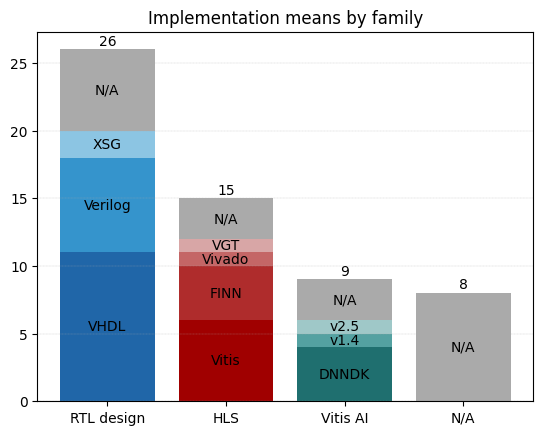

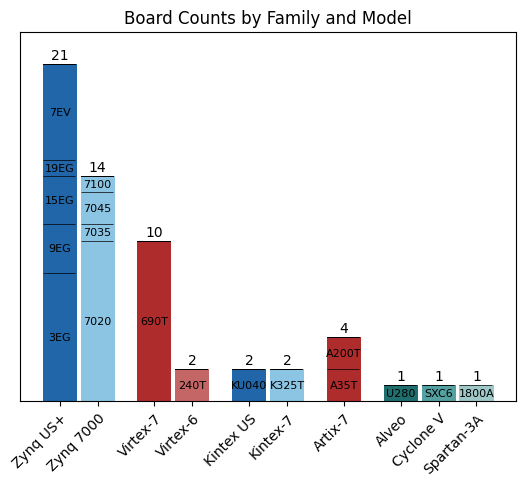

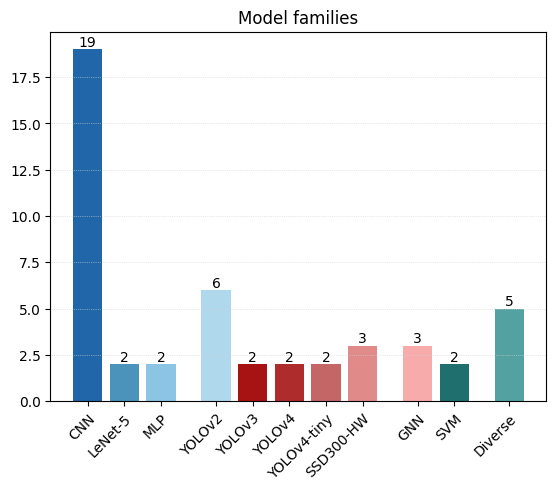

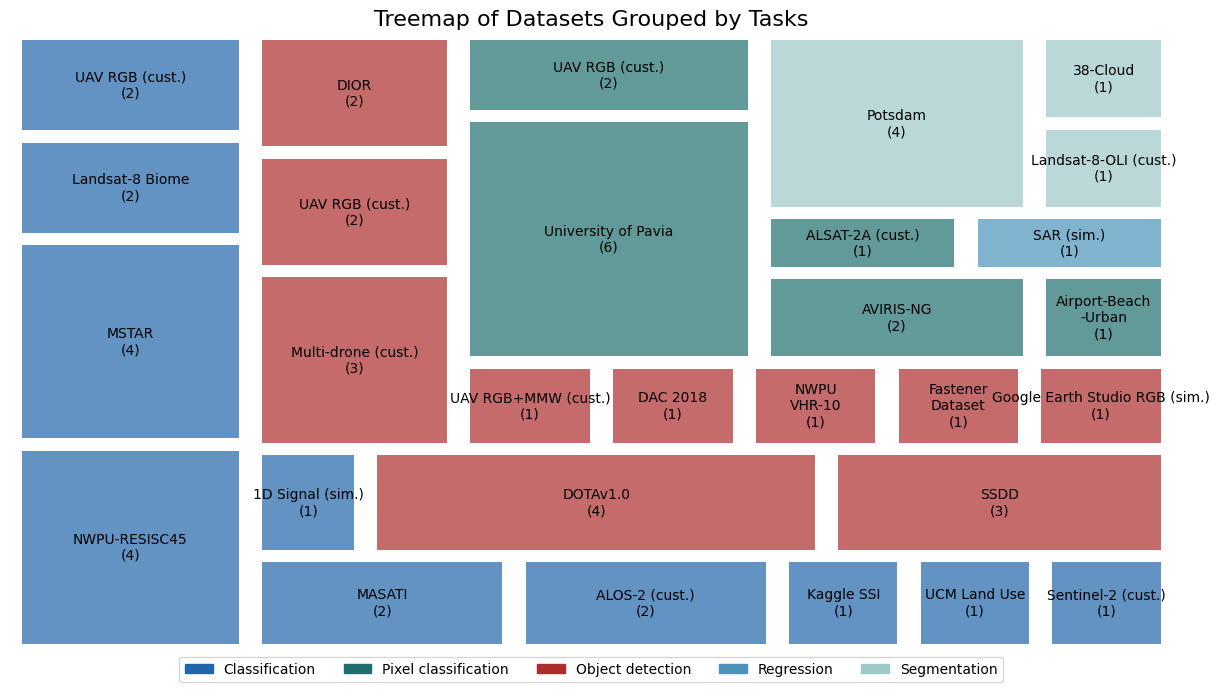

In [83]:
plt.close()

plot_impl_means_by_family_v1(allModelsDF["Implementation"].value_counts())

# print(allModelsDF["Board"].sort_values())
plot_boards_by_family_v2(allModelsDF["Board"].value_counts())

plot_equivalent_models_v1(allModelsDF["Equivalent model"].value_counts())

plot_datasets_v1(allModelsDF[["Task", "Dataset"]])

## Deeper analysis of common dataset and tasks among the dataframe

Check how many models (and paper) use the same datasets

About the mean of implementation on FPGA:

- 20 RTL design: 10 VHDL, 5 Verilog, 1 XSG (@TODO: what is that?) and 4 N/A
- 11 HLS: 3 Vitis, 1 Vivado, 3 FINN, 1 VGT (@TODO: classify with Vitis AI?) and 3 N/A
- 5 Vitis AI
- 6 N/A + 1 ??? (the review)


In [69]:
# For the first 4 datasets, print each model's name, the corresponding article research key and their metric
for dataset in dataset_counts.index[:8]:
    print(f"\n{b}{dataset}{e} dataset:")
    for index, row in allModelsDF.iterrows():
        if row["Dataset"] == dataset:
            print(
                f"    - {r}{row['Model']}{e} from {b}{row['BBT Citation Key']}{e} with board: {r}{row['Board']}{e} ({b}{row['Implementation']}{e}):"
            )
            print(
                f"        Score: {g}{row['Model performance']}{e}, Size: {g}{row['Model size']}{e}, Latency: {g}{row['Model latency']}{e}, Throughput: {g}{row['Model throughput']}{e}, Power: {g}{row['Power consumption']}{e}"
            )


University of Pavia {Pixel classification} dataset:
    - 2D CNN from heConfigurable2D3D2023a with board: Zynq US+ (ZU15EG) {Alinx AXU15EG} (RTL design (N/A)):
        Score: 98.24% OA, Size: 1.2 MB, Latency: 0.097 ms, Throughput: 7.07 GOP/s, Power: 8.4 W
    - 3D CNN from heConfigurable2D3D2023a with board: Zynq US+ (ZU15EG) {Alinx AXU15EG} (RTL design (N/A)):
        Score: 94.09% OA, Size: 0.12 MB, Latency: 1.11 ms, Throughput: 3.808 GOP/s, Power: 8.4 W
    - HybridSN from heConfigurable2D3D2023a with board: Zynq US+ (ZU15EG) {Alinx AXU15EG} (RTL design (N/A)):
        Score: 100% OA, Size: 20.5 MB, Latency: 7.71 ms, Throughput: 13.18 GOP/s, Power: 8.4 W
    - SVM from martinsRealtimeSVMbasedHardware2024 with board: Zynq 7000 (Z7020) {} (RTL design (VHDL)):
        Score: 82.48% AA, Size: , Latency: , Throughput: , Power: 
    - SAM-GNN from chellaswamyFPGAbasedRemoteTarget2024 with board: Virtex-7 (VX690T) {} (RTL design (VHDL)):
        Score: 95.05% OA, Size: , Latency: , Throug

### Analyze common tasks


In [70]:
# For each Task, group by dataset and print each model name and backbones
ml_task_counts = allModelsDF["Task"].value_counts()
for task, value in ml_task_counts.items():
    print(f"\n{b}{task}{e} task (total: {value}):")
    nb_item = 0
    for dataset in dataset_counts.index:
        if dataset.split("{")[1][:-1].strip().upper() == task.upper():
            print(f"    {b}{dataset.split('{')[0].strip()}{e}:")
            for index, row in allModelsDF.iterrows():
                if row["Task"] == task and row["Dataset"] == dataset:
                    print(
                        f"        - {r}{row['Model']}{e} ({row['Equivalent model']}) [{y}{row['Backbone']}{e}] from {b}{row['BBT Citation Key']}{e} with board: {r}{row['Board']}{e} ({row['Implementation']}):"
                    )
                    print(
                        f"            Score: {g}{row['Model performance']}{e}, Size: {g}{row['Model size']}{e}, Latency: {g}{row['Model latency']}{e}, Throughput: {g}{row['Model throughput']}{e}, Power: {g}{row['Power consumption']}{e}"
                    )
                    nb_item += 1

    print(f"    Total: {nb_item}")


Classification task (total: 20):
    MSTAR:
        - Modified LeNet-5 (LeNet-5) [LeNet-5] from weiFPGABasedHybridTypeImplementation2019 with board: Kintex-7 (XC7K325T) {KC705} (RTL design (N/A)):
            Score: 97.77% OA, Size: 1.66 MB, Latency: 2.29 ms, Throughput: , Power: 
        - GNN (GNN) [] from zhangAccurateLowlatencyEfficient2022a with board: Zynq US+ (ZU7EV) {ZCU104} (HLS (N/A)):
            Score: 99.09% OA, Size: 0.96 MB, Latency: 0.105 ms, Throughput: , Power: 6.3 W
        - LeNet-5 (LeNet-5) [LeNet-5] from chenHardwareImplementationConvolutional2020 with board: Kintex-7 (XC7K325T) {} (N/A):
            Score: 98.18% OA, Size: , Latency: 2.29 ms, Throughput: , Power: 
        - GNN (GNN) [] from zhangAcceleratingGNNbasedSAR2023 with board: Alveo (U280) {} (HLS (N/A)):
            Score: , Size: , Latency: 759 FPS, Throughput: 400 GOP/s, Power: 38 W
    NWPU-RESISC45:
        - Improved VGG16 (CNN) [VGG16] from yanAutomaticDeploymentConvolutional2022a with board: Ar

## Creation of the main Figure: a big table

Here is how I think I will proceed. I will have to rebuild a dataset using Multiindex columns and rows for the first 2 rows (Model: Name & Backbone) and the first 3 columns: Task, Modality and Dataset.
Then I use `pandas.io.formats.style.Styler.to_latex` to get the LateX code in the output cell, copy-paste that in my Overleaf and perform the last changes manually, i.e., use LaTeX `\multicolumn{<no of columns>}{<column alignment>}{<content>}` and `multirow{}{}{}` for the look.

In general, go have a deep look at https://www.overleaf.com/learn/latex/Tables for a hands-on @TODO.

**Manual modifications:**

- Replace all '%' by '\%' (using search and replace in VSCode)
- Change columns specification in `\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}`
- Rotate the ML Task multirow with `\parbox[t]{2mm}{\multirow{<NUMBER_OF_CELLS>}{*}{\rotatebox[origin=c]{90}{<YOUR_TEXT>}}}`


In [26]:
# Example data
data = {
    "Task": ["Task1", "Task1", "Task1"],
    "Modality": ["Modality1", "Modality2", "Modality2"],
    "Dataset": ["Dataset1", "Dataset2", "Dataset3"],
    "Model Name": ["Model1", "Model2", "Model3"],
    "Backbone": ["Backbone1", "Backbone2", "Backbone3"],
    "Metric1": [0.9, 0.8, 0.85],
    "Metric2": [0.7, 0.75, 0.8],
}
rawDF = pd.DataFrame(data)
print(rawDF)

multiIndexDF = rawDF.set_index(["Task", "Modality", "Dataset"])
columns = pd.MultiIndex.from_tuples(
    [
        ("Model", "Name"),
        ("Model", "Backbone"),
        ("Metrics", "Metric1"),
        ("Metrics", "Metric2"),
    ]
)
print(multiIndexDF.columns)
multiIndexDF.columns = columns
print("\n", multiIndexDF)

latexCodeDF = multiIndexDF.style.to_latex()
print("\n", latexCodeDF)

    Task   Modality   Dataset Model Name   Backbone  Metric1  Metric2
0  Task1  Modality1  Dataset1     Model1  Backbone1     0.90     0.70
1  Task1  Modality2  Dataset2     Model2  Backbone2     0.80     0.75
2  Task1  Modality2  Dataset3     Model3  Backbone3     0.85     0.80
Index(['Model Name', 'Backbone', 'Metric1', 'Metric2'], dtype='object')

                            Model            Metrics        
                            Name   Backbone Metric1 Metric2
Task  Modality  Dataset                                    
Task1 Modality1 Dataset1  Model1  Backbone1    0.90    0.70
      Modality2 Dataset2  Model2  Backbone2    0.80    0.75
                Dataset3  Model3  Backbone3    0.85    0.80

 \begin{tabular}{lllllrr}
 &  &  & \multicolumn{2}{r}{Model} & \multicolumn{2}{r}{Metrics} \\
 &  &  & Name & Backbone & Metric1 & Metric2 \\
Task & Modality & Dataset &  &  &  &  \\
\multirow[c]{3}{*}{Task1} & Modality1 & Dataset1 & Model1 & Backbone1 & 0.900000 & 0.700000 \\
 & \mul

In [ ]:
# @TODO, rename the columns and get it printed close to a nice format, i.e., that also fit son the Overleaf page and has colors and lines
# I "hide" the columns by not specifying them in the new order

# Choose and order columns
reorderedDF = allModelsDF.loc[:, [
    "Task",
    "Modality",
    "Dataset",
    "BBT Citation Key",
    "Publication year",
    "Model",
    "Backbone",
    "Board",
    "Model performance",
    "Model size",
    "Model latency",
    "Model throughput",
    "Power consumption",
]]

# Rename a few columns
reorderedDF.rename(
    columns={
        "BBT Citation Key": "Article",
        "Publication year": "Year",
        "Model performance": "Score",
        "Model size": "Footprint",
        "Model latency": "Latency",
        "Model throughput": "Throughput",
        "Power consumption": "Power",
    },
    inplace=True,
)

# Add `\cite{}` around the citation keys
reorderedDF["Article"] = reorderedDF["Article"].apply(lambda x: f"\\cite{{{x}}}")

# Rename the board content
def determine_board(boardTag: str) -> str:
    family = boardTag.split("(")[0].strip()
    model = boardTag.split("(")[1].split(")")[0].strip()
    if family == "Zynq US+" or family == "Zynq 7000":
        return model
    elif family == "Kintex US":
        return model[2:]
    elif family == "Alveo":
        return f"{family} {model}"
    else:
        return family
def determine_dataset(datasetTag: str) -> str:
    return datasetTag.split("{")[0].strip()
reorderedDF["Board"] = reorderedDF["Board"].apply(determine_board)
reorderedDF["Dataset"] = reorderedDF["Dataset"].apply(determine_dataset)

sortedDF = reorderedDF.sort_values(by=["Task", "Modality", "Dataset"])

rowIndexedDF = sortedDF.set_index(["Task", "Modality", "Dataset"])

multiIndexColumns = pd.MultiIndex.from_tuples(
    [
        ("Article", "Article"),
        ("Year", "Year"),
        ("Model", "Name"),
        ("Model", "Backbone"),
        ("Board", "Board"),
        ("Metrics", "Score"),
        ("Metrics", "Footprint"),
        ("Metrics", "Latency"),
        ("Metrics", "Throughput"),
        ("Metrics", "Power"),
    ]
)
rowIndexedDF.columns = multiIndexColumns

print(tabulate.tabulate(rowIndexedDF, headers="keys", tablefmt="pretty"))


latexCode = rowIndexedDF.style.to_latex(column_format="|c" * len(rowIndexedDF.columns.levels[0]) + "|", hrules=True)
latexCode = re.sub(r'%', r'\%', latexCode)
# latexCode = re.sub(r'& (\w+) &', r'& \\cite{\1} &', latexCode, count=0)
# print(latexCode)

# Extract the 2 columns (Article and Year) as a dictionary, the keys are the Article and the values are the Year
articleYearDict = {}
for index, row in rowIndexedDF.iterrows():
    articleYearDict[row["Article"]["Article"]] = row["Year"]["Year"]
pprint(articleYearDict)

+----------------------------------------------------------------+--------------------------------------------------------------+------------------+-------------------------------+-----------------------+--------------------+----------------------+--------------------------+------------------------+---------------------------+----------------------+
|                                                                |                    ('Article', 'Article')                    | ('Year', 'Year') |       ('Model', 'Name')       | ('Model', 'Backbone') | ('Board', 'Board') | ('Metrics', 'Score') | ('Metrics', 'Footprint') | ('Metrics', 'Latency') | ('Metrics', 'Throughput') | ('Metrics', 'Power') |
+----------------------------------------------------------------+--------------------------------------------------------------+------------------+-------------------------------+-----------------------+--------------------+----------------------+--------------------------+---------------------

In [46]:
# Read the whole Latex table from a file at ../results/test_table.tex and store it as a string
# Then, for each article in the dictionary, find the article and add " & <year>" afterwards, essentially adding a new column to the table
# Finally, write the new table to a file at ../results/test_table_with_year.tex
with open("../results/test_table.tex", "r") as file:
    latexTable = file.read()
    for article, year in articleYearDict.items():
        latexTable = re.sub(article[1:], rf"{article[1:]} & {year}", latexTable)
    
    with open("../results/test_table_with_year.tex", "w") as newFile:
        newFile.write(latexTable)


#### Classification


In [91]:
# --- Print the dataframe with only model trained for classification, sorted by dataset ---

# Filter the dataframe to keep only the models trained for classification, having less than 4 missing metrics
classification_df = classification_df[classification_df["Missing metrics"] < 4]
# Sort the dataframe by dataset
classification_df = classification_df.sort_values(by="Dataset")

# Print the dataframe with tabulate
print(
    tabulate(
        classification_df[
            [
                "BBT Citation Key",
                "Missing metrics",
                "Model",
                "Equivalent model",
                "Backbone",
                "Dataset",
                "Application",
                # "Board",
                # "Implementation",
                "Model latency",
                "Model performance",
                "Model size",
                "Model throughput",
                "Power consumption",
            ]
        ],
        headers="keys",
        tablefmt="pipe",
    )
)

|    | BBT Citation Key                                    |   Missing metrics | Model            | Equivalent model   | Backbone   | Dataset                                 | Application                      | Model latency   | Model performance   | Model size   | Model throughput   | Power consumption   |
|---:|:----------------------------------------------------|------------------:|:-----------------|:-------------------|:-----------|:----------------------------------------|:---------------------------------|:----------------|:--------------------|:-------------|:-------------------|:--------------------|
| 31 | hashimotoShipClassificationSAR2019a                 |                 3 | CNN              | CNN                |            | Custom (ALOS-2) {Classification}        | Binary ship classification       | 330 ms          | 100% OA             |              |                    |                     |
| 25 | rapuanoFPGAbasedHardwareAccelerator2021a            |             

## Old code from previous data format

Should not run anymore


### Analyze the Hardware

Which FPGA family, specific model and evaluation boards are used?


In [ ]:
# Print all tags
print(
    f"{r}{len(devices_tags)}{e} different device tags, in total {g}{get_total_in_dict_of_lists(devices_tags)}{e} tags:"
)
for tag, keys in devices_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[7:]}"{e}')

# Leave out articles that have "Board: ???" or "Board: N/A"
# @TODO: Create a new dataframe per "datapoint", i.e., per experiment, so papers with several models or board will get as many datapoints

print(
    f"{r}{len(devices_families)}{e} different families, in total {g}{get_total_in_dict(devices_families)}{e}:"
)
for tag, keys in devices_families.items():
    print(f' - {r}{keys:>3}{e} items for {b}"{tag}"{e}')

print(
    f"{r}{len(devices_models)}{e} different models, in total {g}{get_total_in_dict(devices_models)}{e}:"
)
for tag, keys in devices_models.items():
    print(f' - {r}{keys:>3}{e} items for {b}"{tag}"{e}')

print(
    f"{r}{len(devices_boards)}{e} different boards/evaluation kits, in total {g}{get_total_in_dict(devices_boards)}{e}:"
)
for tag, keys in devices_boards.items():
    print(f' - {r}{keys:>3}{e} items for {b}"{tag}"{e}')

33 different device tags, in total 60 tags:
 -   1 items for "Virtex-6"
 -   1 items for "Kintex US rad-hard (XQRKU060)"
 -   1 items for "Zynq US+ (ZU7EV) {ZCU106}"
 -   1 items for "Zynq 7000 (Z7020) {PYNQ-Z2}"
 -   1 items for "Zynq US+ (ZU3EG) {UltraZed-EG}"
 -   3 items for "Virtex-7 (VX690T)"
 -   1 items for "Zynq US+ (ZU3EG) {OVC3}"
 -   1 items for "Zynq US+ (ZU9EG)"
 -   3 items for "Zynq 7000 (Z7020)"
 -   3 items for "Virtex-7 (VX690T) {VC709}"
 -   2 items for "Zynq 7000 (Z7020) {Zedboard}"
 -   1 items for "Artix-7 (XC7A35T) {Arty-35T}"
 -   1 items for "Zynq 7000 (Z7035)"
 -   3 items for "Zynq 7000 (Z7020) {PYNQ-Z1}"
 -   1 items for "Kintex US (XCKU040) {KCU105}"
 -   5 items for "Zynq US+ (ZU7EV) {ZCU104}"
 -   1 items for "Zynq 7000 (Z7020) {Z-turn}"
 -   1 items for "Zynq US+ (ZU15EG) {Alinx AXU15EG}"
 -   1 items for "Alveo U280"
 -   1 items for "Zynq US+ (ZU9EG) (Kria KV260)"
 -   2 items for "Cyclone V (5CSXC6)"
 -   1 items for "Virtex-6 (XC6VLX240T)"
 -  13 it

In [ ]:
# For all included articles, track tags starting by "Board: ", "Task: ", Model: " and "Implementation: "
# Some items may have multiple tags, so we need to track the number of items for each tag
devices_tags = {}
tasks_tags = {}
models_tags = {}
implementations_tags = {}
modalities_tags = {}
miscellaneoustags = {}

# --- Split tags into categories ---
for key in selected_articles_df.index:
    tags = selected_articles_df.loc[key, "Tags"]
    for tag in tags:
        if tag.startswith("Board: "):
            if tag not in devices_tags:
                devices_tags[tag] = []
            devices_tags[tag].append(key)
        elif tag.startswith("Task: "):
            if tag not in tasks_tags:
                tasks_tags[tag] = []
            tasks_tags[tag].append(key)
        elif tag.startswith("Model: "):
            if tag not in models_tags:
                models_tags[tag] = []
            models_tags[tag].append(key)
        elif tag.startswith("Implementation: "):
            if tag not in implementations_tags:
                implementations_tags[tag] = []
            implementations_tags[tag].append(key)
        elif tag.startswith("Modality: "):
            if tag not in modalities_tags:
                modalities_tags[tag] = []
            modalities_tags[tag].append(key)
        else:
            if tag not in miscellaneoustags:
                miscellaneoustags[tag] = []
            miscellaneoustags[tag].append(key)

# Split devices tags into 3 further dictionnaries: Family, model and board/evaluation kit
devices_families = {}
devices_models = {}
devices_boards = {}
for tag in devices_tags:
    # Each tag is formatted like "Board: family (model) {board/evaluation kit}", sometimes there is no board/evaluation kit
    # Example: "Board: Zynq 7000 (Z7020) {PYNQ-Z1}" or "Board: Kintex US (KU115)"
    family = tag.split(" (")[0].split(": ")[1]
    model = tag.split(" (")[1].split(")")[0] if "(" in tag else None
    board = tag.split("{")[1].split("}")[0] if "{" in tag else None
    if family not in devices_families:
        devices_families[family] = 0
    devices_families[family] += len(devices_tags[tag])
    if model not in devices_models:
        devices_models[model] = 0
    devices_models[model] += len(devices_tags[tag])
    if board not in devices_boards:
        devices_boards[board] = 0
    devices_boards[board] += len(devices_tags[tag])

# --- Print the number of articles for each tag ---
print("Number of articles with the corresponding tags:")
print(
    f"{r}{get_total_in_dict_of_lists(devices_tags)}{e} boards, "
    f"{r}{get_total_in_dict_of_lists(tasks_tags)}{e} tasks, "
    f"{r}{get_total_in_dict_of_lists(models_tags)}{e} models, "
    f"{r}{get_total_in_dict_of_lists(implementations_tags)}{e} implementations and "
    f"{r}{get_total_in_dict_of_lists(modalities_tags)}{e} modalities"
)

Number of articles with the corresponding tags:
60 boards, 58 tasks, 72 models, 57 implementations and 53 modalities


In [ ]:
print("\n\n\n")

# Statistics about Implementation means
print(
    f"{r}{len(implementations_tags)}{e} different implementations, in total {g}{get_total_in_dict_of_lists(implementations_tags)}{e}:"
)
for tag, keys in implementations_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[16:]}"{e}')

# Statistics about the downstream Tasks
print(
    f"{r}{len(tasks_tags)}{e} different tasks, in total {g}{get_total_in_dict_of_lists(tasks_tags)}{e}:"
)
for tag, keys in tasks_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[6:]}"{e}')

# Statistics about the Models
print(
    f"{r}{len(models_tags)}{e} different models, in total {g}{get_total_in_dict_of_lists(models_tags)}{e}:"
)
for tag, keys in models_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[7:]}"{e}')

# Statistics about the Modalities
print(
    f"{r}{len(modalities_tags)}{e} different modalities tags, in total {g}{get_total_in_dict_of_lists(modalities_tags)}{e}:"
)
for tag, keys in modalities_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag}"{e}')

In [38]:
pprint(zot.item(articles_selected_for_review[0]))
pprint(zot.item(articles_selected_for_review[1]))

{'data': {'DOI': '10.1109/TIE.2017.2708028',
          'ISSN': '1557-9948',
          'abstractNote': 'The Fuzzy ARTMAP is a supervised learning method, '
                          'providing high accuracy in many classifications. In '
                          'this paper, we explore the role of hardware '
                          'accelerators in remote sensing classification '
                          'missions. We focus on the designing and '
                          'implementing a massively parallel hardware '
                          'architecture on a field-programmable gate array '
                          "(FPGA) of the performance phase's algorithm. The "
                          'implementation is mapped on Xilinx Virtex 6 '
                          'XC6VLX240T FPGA chip for an embedded system using '
                          'Xilinx ISE 14.5 software. Embedded blocks dedicated '
                          'to digital signal processing (DSP) and blocks '
            